# Testing the model

## 0. Importing the libraries

In [6]:
import PIL.Image
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
import torch.nn as nn
import pathlib
import os
import numpy as np
import torchinfo

try:
    from scripts import model_setup
    from scripts import utilities
except ImportError:
    !git clone https://github.com/thomaspierantozzi/PyTorch_Course_by_Daniel_Bourke
    !mv PyTorch_Course_by_Daniel_Bourke/05_PyTorch_Food101/scripts/ .
    !rm -rf ./PyTorch_Course_by_Daniel_Bourke
    from scripts import model_setup


## 1. Importing the trained model

In [7]:
MODEL_FOLDER = pathlib.Path('./models/05_Birdsnap_ViT_SWAG_Weights_100_classes')
model_to_test = model_setup.ViT_B_16(name='ViT_B_16', SWAG_weights=True)

with open(MODEL_FOLDER / 'model_checkpoint_epoch_10.pt', 'rb') as pretrained_model:
    checkpoint = torch.load(pretrained_model, map_location=torch.device('cpu'))
    
#rebuilding the classifier layer as per what we set back at training time
model_to_test.pre_trained_model.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=100),
)


In [8]:
model_to_test.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

#### First off, we consider the CV dataset. We predict the classes again and we try to dig a bit deeper into the results via a confusion matrix (if readable) or similar tools.
#### Then we will consider a test set and we see how accurate the model is. 
#### <font color='orange'>Most likely, actually, we will consider not only a single test set but two instead:</font>
#### * The first one will be a test set with pictures in "good" light conditions and coming from professional shots: they ten d to be well defined, centered, zoomed around the subject and, thus, giving an optimal base for a classification model
#### * The second one will be a dataset of shots which resemble the most to what actually a standard user can take with their smartphone or everyday camera.


In [9]:
transform_pipeline = nn.Sequential(
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    model_to_test.transformers()
)

transform_pipeline

Sequential(
  (0): ToImage()
  (1): ToDtype(scale=True)
  (2): ImageClassification(
      crop_size=[384]
      resize_size=[384]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BICUBIC
  )
)

#### Rebuilding a dataset with the CV data

In [10]:
cv_dataset = ImageFolder(
    root=pathlib.Path('./ImageFolder/cv'),
    transform=transform_pipeline
)
cv_dataset

Dataset ImageFolder
    Number of datapoints: 874
    Root location: ImageFolder/cv
    StandardTransform
Transform: Sequential(
             (0): ToImage()
             (1): ToDtype(scale=True)
             (2): ImageClassification(
                 crop_size=[384]
                 resize_size=[384]
                 mean=[0.485, 0.456, 0.406]
                 std=[0.229, 0.224, 0.225]
                 interpolation=InterpolationMode.BICUBIC
             )
           )

In [11]:
print(f'The number of classes in the cv dataset are: {len(cv_dataset.class_to_idx)}')

The number of classes in the cv dataset are: 100


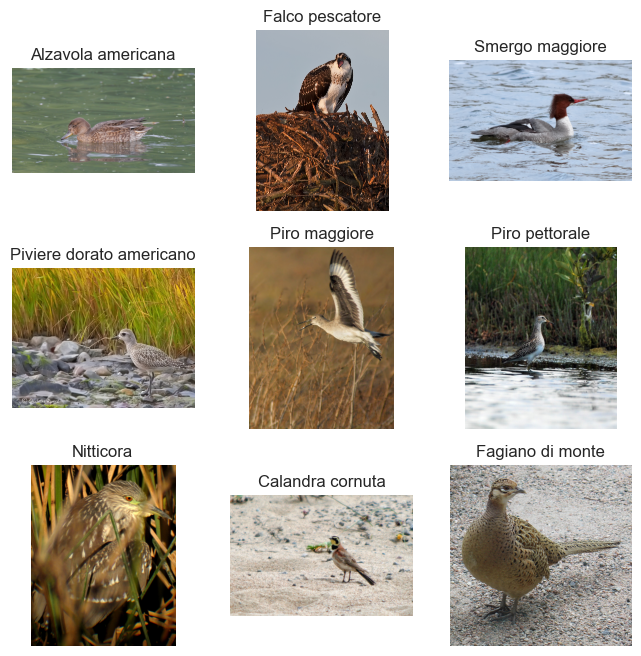

In [15]:
utilities.plot_samples(
    path=pathlib.Path('./ImageFolder/cv'),
    classes_names=cv_dataset.class_to_idx
)

In [16]:
BATCH_SIZE = 32
cv_dataloader = DataLoader(
    dataset=cv_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4,
)

In [18]:
device = 'mps' if torch.mps.is_available() else 'cpu'

In [19]:
from tqdm import tqdm
import torch.nn.functional as F
import pickle

prediction_list = []
target_list = []

model_to_test.eval()
model_to_test.to(device)

if not (MODEL_FOLDER / 'prediction_logits.pkl').exists():
    with torch.no_grad():
        for test_batch, target_batch in tqdm(cv_dataloader, desc='Testing the model'):
            test_batch, target_batch = test_batch.to(device), target_batch.to(device)
            
            pred_logits_batch = model_to_test(test_batch)
    #        pred_proba_batch = F.softmax(pred_logits_batch, dim=1)
    #        prediction_batch = torch.argmax(pred_proba_batch, dim=1)
            
            prediction_list.append(pred_logits_batch)
            target_list.append(target_batch)
    prediction_logits = torch.cat(prediction_list, dim=0)
    targets = torch.cat(target_list, dim=0)
else:
    with open(MODEL_FOLDER / 'prediction_logits.pkl', 'rb') as f:
        prediction_logits = pickle.load(f)
    
    targets = torch.as_tensor([target[1] for target in cv_dataset]) #collecting all the ground truth labels from the cv_dataset
            
print(f'Prediction logits_shape: {prediction_logits.shape}')
model_acc = model_to_test.accuracy(
    target=targets,
    prediction=prediction_logits
)

Testing the model: 100%|██████████| 28/28 [01:06<00:00,  2.37s/it]

Prediction logits_shape: torch.Size([874, 100])


#### Let's save the prediction in a pickle file in order to avoid predicting over and over again the results while tuning the notebook

In [20]:
with open(MODEL_FOLDER / 'prediction_logits.pkl', 'wb') as f:
    pickle.dump(prediction_logits, f)
    

In [21]:
print(f'The model shows an accuracy of: {model_acc:.3%}')

The model shows an accuracy of: 74.142%


In [22]:
prediction_proba = F.softmax(torch.as_tensor(prediction_logits), dim=1)
prediction = prediction_proba.argmax(dim=1)

In [25]:
prediction

tensor([ 0,  0,  1,  0,  0, 10,  0,  0,  0,  1,  1,  1, 18,  1,  1,  1,  1,  1,
         2,  2, 96, 40,  2,  2, 30,  2,  2, 43,  3,  2,  3,  3,  3,  3,  3,  2,
         4, 41,  4,  4,  4,  4,  4,  4,  5, 22, 17,  5,  5, 42,  5,  5, 46,  6,
         6, 49,  8,  6,  6, 89,  7,  7,  7,  7,  7,  7,  7,  7,  8, 30,  8, 57,
        62, 41, 95,  8,  8, 75, 85,  9,  9, 11,  9,  9,  9, 13, 71, 10, 10, 10,
        10, 10, 37, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 30, 12, 12, 12, 12,
        12, 12, 12, 85, 81, 13, 13, 13, 14, 13, 13, 13, 13, 13, 49, 14, 14, 14,
        14, 14, 14, 27, 15, 15, 15, 15,  0, 15, 15, 15, 16, 16, 16, 16, 16, 36,
        16, 17, 17, 17, 17, 17, 17, 79, 17, 17, 17, 18, 18, 18, 66, 18, 18, 18,
        18, 19, 52, 90, 74, 30, 19, 19, 19, 24, 20, 73,  8, 20, 20, 20, 20, 20,
        21, 21, 21, 21, 21, 21, 60, 21, 22, 22, 22, 22, 12, 22, 22, 23, 32, 23,
        22, 23, 22, 23, 23, 24, 25, 24, 24, 24, 24, 24, 24, 24, 25, 51,  8, 25,
        24, 25, 25, 26, 26, 26, 26, 26, 

Text(0.5, 1.0, 'Confusion Matrix')

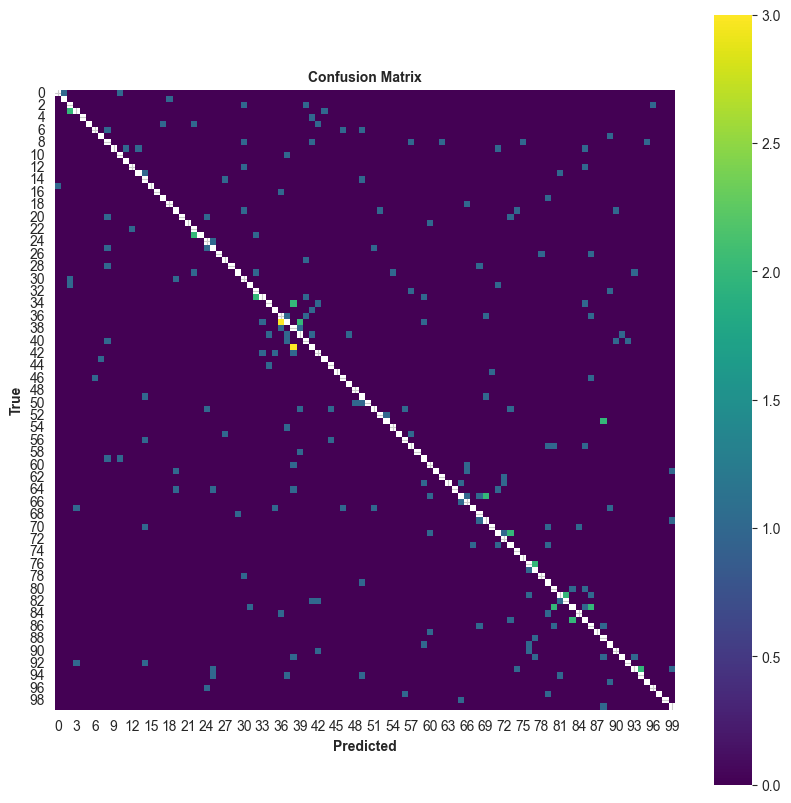

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import numpy as np

mask = np.eye(N=len(cv_dataset.class_to_idx), M=len(cv_dataset.class_to_idx), dtype=np.bool)

plt.figure(figsize=(10, 10))
heatmap(
    confusion_matrix(targets.to('cpu'), prediction.to('cpu')),
    square=True,
    cmap='viridis',
    mask=mask,
)
FONT_SIZE = 10
plt.xlabel('Predicted', fontsize=FONT_SIZE, fontweight='bold')
plt.ylabel('True', fontsize=FONT_SIZE, fontweight='bold')
plt.title('Confusion Matrix', fontsize=FONT_SIZE, fontweight='bold')

#### Let's give a look at random pictures of the cv dataset and how they're labelled by the ML model

#### We import a dictionary containing the translation of the english common names to italian common names...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8425452..1.4910349].


(np.float64(-0.5), np.float64(383.5), np.float64(383.5), np.float64(-0.5))

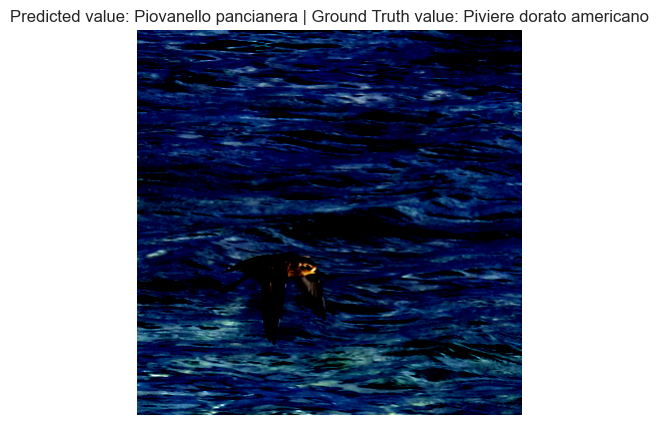

In [52]:
from random import randint

random_pic_index = randint(0, len(cv_dataset) - 1)
random_pic = cv_dataset[random_pic_index][0]
random_pic_true_label = cv_dataset[random_pic_index][1]

ground_truth_label = [label for label, integer in cv_dataset.class_to_idx.items() if integer == random_pic_true_label][0]
predicted_label = [label for label, integer in cv_dataset.class_to_idx.items() if integer == prediction[random_pic_index]][0] 

#let's plot the random picture and its prediction vs. ground truth label
plt.figure(figsize=(5, 5))
plt.imshow(random_pic.permute(1, 2, 0))
plt.title(f'Predicted value: {predicted_label} | Ground Truth value: {ground_truth_label}')
plt.grid(False)
plt.axis('off')

In [53]:
import json
with open('./classes_idx.json', 'w+') as f:
    json.dump(cv_dataset.class_to_idx, f, indent=4)